In [1]:
import pandas as pd
import requests
import os
import cv2
import json
import numpy as np

vote_count_fpath = 'test/[WeVis] They Work for Us - Politician Data - [T] PeopleVote.csv'
vote_fpath = 'test/[WeVis] They Work for Us - Politician Data - [T] Votelog.csv'

In [2]:
# images_p = [os.path.join('test/pdf/20190823113634A11', f) for f in os.listdir('test/pdf/20190823113634A11')]
# images = [cv2.imread(f) for f in images_p]

In [3]:
def parse_text(image):
      gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
      blured = cv2.GaussianBlur(gray, (1, 9), 0)
      th, threshed = cv2.threshold(blured, 200, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
      threshed = cv2.dilate(threshed, kernel)
      hist = cv2.reduce(threshed, 1, cv2.REDUCE_AVG).reshape(-1)

      kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 2))
      dilated = cv2.dilate(threshed, kernel)
      contours, hier  = cv2.findContours(
            dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
      rects = [cv2.boundingRect(c) for c in contours]
      rects.sort(key=lambda rect: rect[1])

      return rects


In [4]:
pdf_dir = 'test/pdf'
images = {}
for dirpath, dir, filenames in os.walk(pdf_dir):
  # if dirpath == pdf_dir: continue
  for fname in filenames:
    if not fname.endswith('.png'): continue
    fpath = os.path.join(dirpath, fname)
    image = cv2.imread(fpath)
    images[fpath] = image
    # if len(images.keys()) > 10: break



In [5]:
pred = []
image_boxes = []
for fpath, image in images.items():
  boxes = parse_text(image)
  image_boxes.append(boxes)
      

In [6]:
def label_studio_input(box, labels, image):
  x, y, width, height = box
  image_height, image_width, _ = image.shape
  return {
    "original_width": image_width,
    "original_height": image_height,
    "image_rotation": 0,
    "value": {
      "x": x/image_width*100,
      "y": y/image_height*100,
      "width": width/image_width*100,
      "height": height/image_height*100,
      "rotation": 0,
      "rectanglelabels": labels},
    "from_name": "label",
    "to_name": "image",
    "type": "rectanglelabels",
  }

In [7]:
with open('ds/pred.json', 'w') as f:
  json.dump(pred, f, indent=3)

# validate

In [8]:
import numpy as np

In [9]:
size = []
for impred in pred:
  for prediction in impred['predictions']:
    new_res = []
    for result in prediction['result']:
      w = result['value']['width']
      h = result['value']['height']
      size.append(w*h)
      if w*h > 1:
        new_res.append(result)
    # annot['result'] = list()
    # annot['predictions'] = new_res

# Column

In [10]:
def detect_column(images):
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 5))
  hist_avg = None
  for im in images:
    gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    th, threshed = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(threshed, kernel, iterations=3)

    if hist_avg is None:
      hist_avg = cv2.reduce(dilated, 0, cv2.REDUCE_AVG)
    else:
      hist_avg = (hist_avg + cv2.reduce(dilated, 0, cv2.REDUCE_AVG)) / 2

  hist_avg = hist_avg.reshape(-1)

  lined = im.copy()
  hist_b = hist_avg < hist_avg.max() - hist_avg.std()
  cols1 = np.argwhere(hist_b[1:] & (hist_b[1:] ^ hist_b[:-1])).reshape(-1)
  cols2 = np.argwhere(hist_b[:-1] & (hist_b[1:] ^ hist_b[:-1])).reshape(-1)
  cols = (cols1 + ((cols1 - cols2) * 0.8)).astype(int)

  return cols

In [11]:
def outer_box(boxes):
  x0 = boxes[:, 0]
  x1 = (x0 + boxes[:, 2]).max()
  x0 = x0.min()
  y0 = boxes[:, 1]
  y1 = (y0 + boxes[:, 3]).max()
  y0 = y0.min()
  return (x0, y0, x1-x0, y1-y0)


In [12]:
def draw_boxes(boxes, image, self=None):
  canvas = image.copy()
  for x, y, w, h in boxes:
    canvas = cv2.rectangle(canvas, (x, y), (x+w, y+h), 255, 1)
  if self is not None:
    x, y, w, h = self
    canvas = cv2.rectangle(canvas, (x, y), (x+w, y+h), 1, 2)
  x0, y0, w, h = outer_box(boxes)
  canvas = cv2.rectangle(canvas, (x0, y0), (x0+w, y0+h), (100, 100, 1000), 1)
  return canvas

In [13]:
def line(sorted_boxes: np.array) -> np.array:
  # create -1 matrix
  box_line_num = np.zeros(len(sorted_boxes))
  box_line_num.fill(-1)
  # sorting by x axis

  i = 0
  line_image = image.copy()
  while (box_line_num == -1).any():
    if box_line_num[i] != -1:
      i += 1
      continue
    center = sorted_boxes[:, 1] + (sorted_boxes[:, 3]/2)
    angle = np.arctan2((center - center[i]), (sorted_boxes[:, 0] - sorted_boxes[i, 0]))

    is_in_line = (np.abs(angle) < 0.03)
    is_in_line_index = np.argwhere(is_in_line).reshape(-1)

    line_boxes = sorted_boxes[is_in_line_index]
    box_line_num[is_in_line] = i

    i += 1
  
  return box_line_num

In [14]:
def row_span_in_page(line_nums, boxes):
  lnums = np.unique(line_nums) # unique line number
  boxes_in_lines = [boxes[line_nums == i] for i in lnums]
  row_spans = np.array([outer_box(b) for b in boxes_in_lines])
  thred = (row_spans[:, 2].mean() - row_spans.std()/2)
  row_indexes = np.where(row_spans[:, 2] > thred)
  row_spans = row_spans[row_indexes]
  return row_spans


In [21]:
def column_markers(image, boxes, table):
  empty_image = np.zeros(image.shape)
  empty_image.fill(255)
  x_hist = np.zeros(image.shape[1])
  tx, ty, tw, th = table
  for x, y, w, h in boxes:
    if x >= tx and y >= ty and x+w <= tx+tw and y+h <= ty+th:
      x_hist[x:x+w] += h
      empty_image[y:y+h, x:x+w] = 0
  bxhist = x_hist.astype(bool)
  bxor = np.logical_xor(bxhist[1:], bxhist[:-1])
  col_marks = np.argwhere(bxor)
  if col_marks.size % 2:
    col_marks = np.append(col_marks, [table[1]+table[3]])
  col_marks = col_marks.reshape(col_marks.size//2, 2)
  columns = []
  for x0, x1 in col_marks:
    columns.append((x0, table[1], x1-x0, table[3]))
  columns = np.array(columns)
  return columns

In [22]:
def filter(boxes):
  size_filter = (boxes[:, 2]*boxes[:, 3] > 300)
  ratio_filter = (boxes[:, 2]/boxes[:, 3] > 0.5)
  return size_filter & ratio_filter

In [23]:
def append_rectangles(to, boxes, labels):
  for box in boxes:
    to.append({'box': box,'labels': labels})


In [24]:
for (fpath, image), boxes in zip(images.items(), image_boxes):
  if not fpath.endswith('00.png'): continue
  break
boxes.sort(key=lambda x: x[0])
boxes = np.array(boxes)

In [25]:
def process_data(image, boxes, fpath):
  boxes.sort(key=lambda x: x[0])
  boxes = np.array(boxes)
  
  rectangles = list()
  boxes = boxes[filter(boxes)]
  append_rectangles(rectangles, boxes, ['text'])

  line_nums = line(boxes)

  row_spans = row_span_in_page(line_nums, boxes)
  append_rectangles(rectangles, row_spans, ['table row'])

  table = outer_box(row_spans)
  append_rectangles(rectangles, [table], ['table'])
  # canvas = draw_boxes(row_spans, image)

  column_spans = column_markers(image, boxes, table)
  append_rectangles(rectangles, column_spans, ['table column'])
  # canvas = draw_boxes(column_pairs, canvas)

  # cv2.imwrite('draw.png', canvas);

  return {
    "data": {
      "ocr": f"/data/local-files/?d={os.path.abspath(fpath)}"
    },
    "predictions": [{
        "model_version": "0.0.2",
        "result": [label_studio_input(rect['box'], rect['labels'], image) for rect in rectangles],
      }]
  }

In [26]:
importdata = [process_data(image, boxes, fpath) for (fpath, image), boxes in zip(images.items(), image_boxes)]

In [27]:
with open('ds/pred.json', 'w') as fp:
  json.dump(importdata, fp)

# Add salt&pepper

In [1]:
import cv2
import numpy as np
from PIL import Image

In [2]:
image = cv2.imread('test/pdf/20190823113634A11-01.png',0)

In [165]:
def add_noise(image, prop):
    fmask=np.random.rand(*image.shape[:2])
    mask = np.where(fmask<prop)
    image[mask] = 0
    return image

def get_pepper(image):
    noise = image.copy()
    noise.fill(255)
    
    original_h,original_w=image.shape[:2]
    nit = 5
    for i in range(nit):
        div = (nit-i)*2
        h=original_h//div
        w=original_w//div
        noise = cv2.resize(noise, (w,h))
        noise = add_noise(noise, prop=0.0005)
    noise = cv2.resize(noise, (original_w,original_h))
    ret,thes = cv2.threshold(noise,150,255,cv2.THRESH_BINARY)
    return thes

def mask_noise(image):
    noise = image.copy()
    noise.fill(250)
    
    original_h,original_w=image.shape[:2]
    nit = 5
    for i in range(nit):
        div = (nit-i)*3
        h=original_h//div
        w=original_w//div
        noise = cv2.resize(noise, (w,h))
        noise = add_noise(noise,0.02*div)
    noise = cv2.resize(noise, (original_w,original_h))
    ret,thes = cv2.threshold(noise,110,255,cv2.THRESH_BINARY)
    return thes

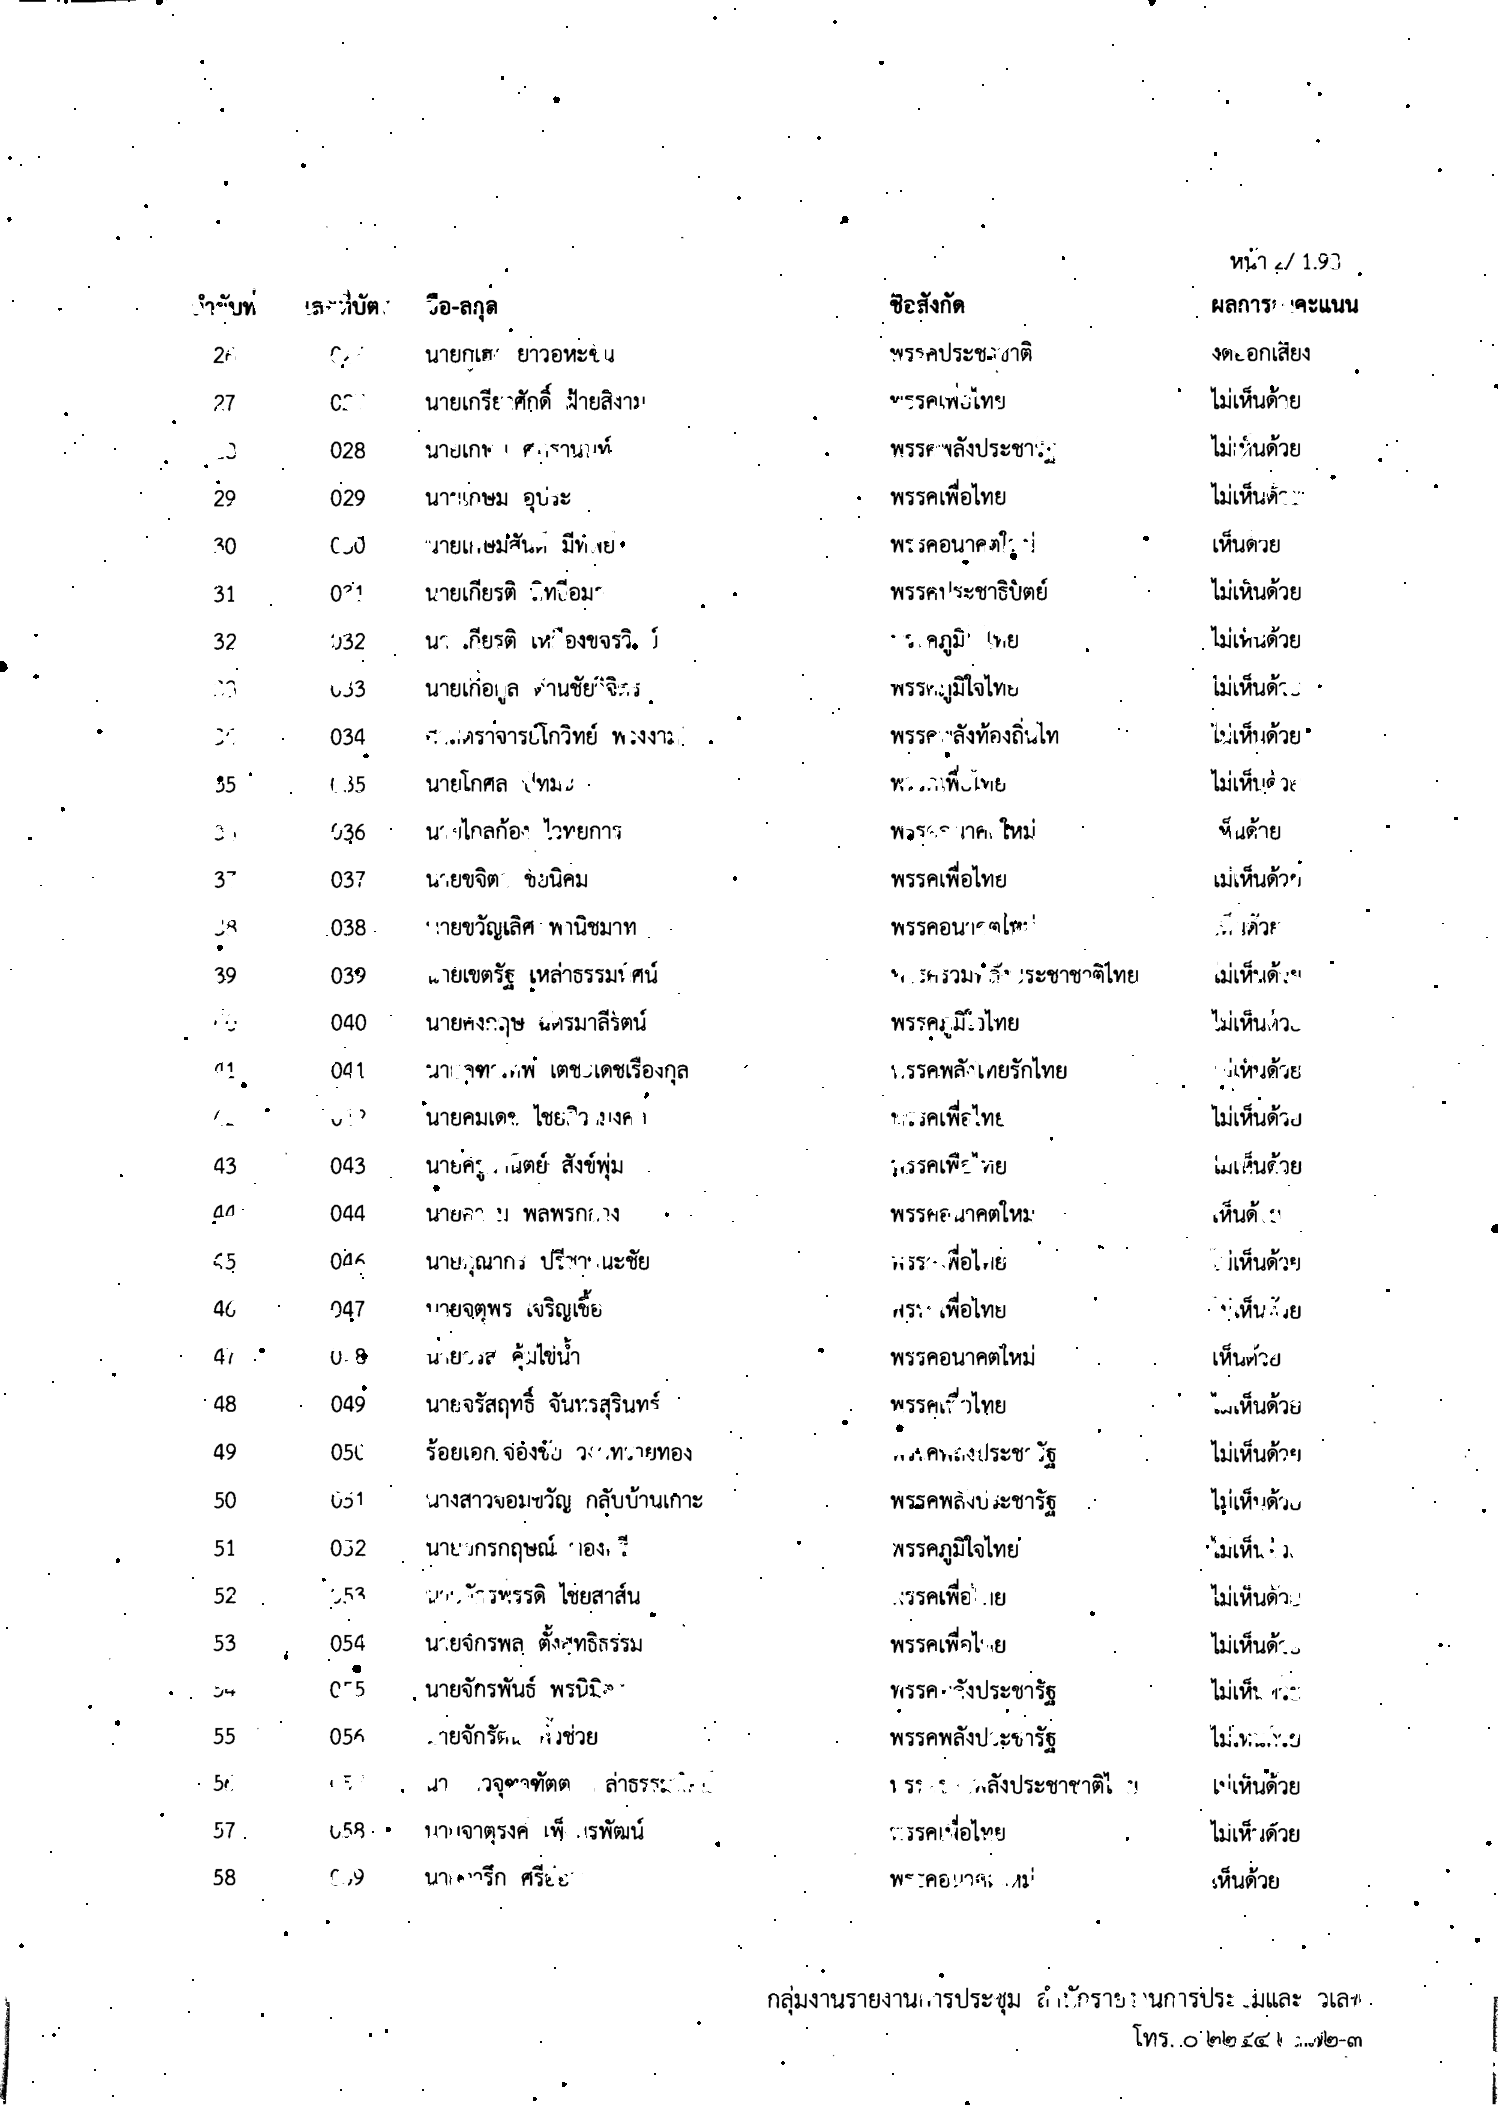

In [173]:
pepper = get_pepper(image)
ming = cv2.add(mask_noise(image),image)
nimg = cv2.bitwise_and(ming, pepper)
Image.fromarray(nimg)